# Requirements

In [3]:
import sddk
import pandas as pd
import requests
pd.options.display.max_columns = 1000 # to see all columns
import json
import re
import nltk
import warnings
import pickle
from functools import partial
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
sys.setrecursionlimit(1000000)
from bs4 import BeautifulSoup

In [4]:
import pyproj
from shapely.ops import transform
from shapely.geometry import Point
import geopandas as gpd
from scipy.spatial import cKDTree
#import geoplot as gplt
from pyproj import Geod
from shapely.geometry import LineString

# Import datasets

In [3]:
# read edh dataset
try: #
    EDH = pd.read_json("../../EDH_ETL_repo/data/large_data/EDH_text_cleaned_2022-11-03.json") # or replace by your own local path to the latest version of EDH
except:
    publicfolder = "b6b6afdb969d378b70929e86e58ad975"
    EDH = sddk.read_file("EDH_text_cleaned_2022-11-03.json", "df", publicfolder)

In [4]:
EDH.shape # previously we had (81476, 74)

(81883, 69)

In [5]:
# read edcs dataset
try:
    EDCS = pd.read_json("../data/large_data/EDCS_text_cleaned_2022-09-12.json") # or replace by your own local path to the latest version of EDCS
except:
    publicfolder = "1f5f56d09903fe259c0906add8b3a55e"
    EDCS = sddk.read_file("EDCS_text_cleaned_2022-09-12.json", "df", publicfolder)
    EDCS.to_json("../data/large_data/EDCS_text_cleaned_2022-09-12.json")

In [6]:
EDCS.shape

(537262, 27)

In [7]:
EDCS.head()

,EDCS-ID,publication,province,place,inscription,inscription_conservative_cleaning,inscription_interpretive_cleaning,inscr_type,status_notation,inscr_process,clean_text_conservative,clean_text_interpretive_word,status,material,partner_link,dating_from,dating_to,date_not_before,date_not_after,latitude,longitude,photo,raw_dating,language,comment,extra_text,extra_html
0,EDCS-31400030,"CIL 03, 12297",Achaia,?,Leius,Leius,Leius,{},{},{},Leius,Leius,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None
1,EDCS-24700151,"CIL 01, 02650 (p 1097) = IG-05-01, 00741 = ILL...",Achaia,Afesou,Δέκιος Λείβιος (Ζ)εῦξις // D(ecimi) Leivei D(e...,Δέκιος Λείβιος εῦξις D Leivei D Leivei salve,Δέκιος Λείβιος Ζεῦξις Decimi Leivei Decimi Lei...,tituli sepulcrales,"[praenomen et nomen, viri]",{},Δέκιος Λείβιος εῦξις D Leivei D Leivei salve,Δέκιος Λείβιος Ζεῦξις Decimi Leivei Decimi Lei...,praenomen et nomen; tituli sepulcrales; viri,lapis,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None
2,EDCS-24900077,"CIL 01, 00746 (p 944) = D 00867 = ILLRP 00374 ...",Achaia,Agia Triada / Merbaka / Midea,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metello imperatori I...,tituli honorarii,"[officium/professio, ordo senatorius, tria nom...",{},Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metello imperatori I...,officium/professio; ordo senatorius; tituli ...,None,http://db.edcs.eu/epigr/partner.php?s_language...,-68.0,-68.0,-68.0,-68.0,37.638113,22.805299,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,-68 to -68,None,None,None,None
3,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Agios Athanasios / Photike,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piissimo Caesari d n Gal Val P F...,Fortissimo et Piissimo Caesari domino nostro G...,tituli honorarii,"[Augusti/Augustae, ordo equester, tria nomina]",litterae erasae,Fortissimo et Piissimo Caesari d n Gal Val P F...,Fortissimo et Piissimo Caesari domino nostro G...,Augusti/Augustae; litterae erasae; ordo eque...,None,http://db.edcs.eu/epigr/partner.php?s_language...,309.0,313.0,309.0,313.0,39.451218,20.766767,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,309 to 313,None,None,None,None
4,EDCS-55701593,"AE 2009, 01286a",Achaia,Agios Donatos / Photike,Cn(aeus) Atei(us),Cn Atei,Cnaeus Ateius,tituli fabricationis,"[praenomen et nomen, viri]",sigilla impressa,Cn Atei,Cnaeus Ateius,praenomen et nomen; sigilla impressa; tituli...,opus figlinae,None,NaN,NaN,NaN,NaN,39.475976,20.506908,None,None,None,None,None,None


In [8]:
# replace empty dicts and Nones by np.non
def clean_empty(el):
    if isinstance(el,dict):
        if ~bool(el):
            el = np.nan
    elif el == None: #(el == np.nan) | (el == math.nan) | (str(el)=="NaN"):
        el = np.nan
    else:
        el = el
    return el
for col in EDCS.columns:
    clean_col = EDCS[col].apply(clean_empty)
    EDCS[col] = clean_col

for col in EDH.columns:
    clean_col = EDH[col].apply(clean_empty)
    EDH[col] = clean_col

In [9]:
EDCS.head(5)

,EDCS-ID,publication,province,place,inscription,inscription_conservative_cleaning,inscription_interpretive_cleaning,inscr_type,status_notation,inscr_process,clean_text_conservative,clean_text_interpretive_word,status,material,partner_link,dating_from,dating_to,date_not_before,date_not_after,latitude,longitude,photo,raw_dating,language,comment,extra_text,extra_html
0,EDCS-31400030,"CIL 03, 12297",Achaia,?,Leius,Leius,Leius,NaN,NaN,NaN,Leius,Leius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EDCS-24700151,"CIL 01, 02650 (p 1097) = IG-05-01, 00741 = ILL...",Achaia,Afesou,Δέκιος Λείβιος (Ζ)εῦξις // D(ecimi) Leivei D(e...,Δέκιος Λείβιος εῦξις D Leivei D Leivei salve,Δέκιος Λείβιος Ζεῦξις Decimi Leivei Decimi Lei...,tituli sepulcrales,"[praenomen et nomen, viri]",NaN,Δέκιος Λείβιος εῦξις D Leivei D Leivei salve,Δέκιος Λείβιος Ζεῦξις Decimi Leivei Decimi Lei...,praenomen et nomen; tituli sepulcrales; viri,lapis,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EDCS-24900077,"CIL 01, 00746 (p 944) = D 00867 = ILLRP 00374 ...",Achaia,Agia Triada / Merbaka / Midea,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metello imperatori I...,tituli honorarii,"[officium/professio, ordo senatorius, tria nom...",NaN,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metello imperatori I...,officium/professio; ordo senatorius; tituli ...,NaN,http://db.edcs.eu/epigr/partner.php?s_language...,-68.0,-68.0,-68.0,-68.0,37.638113,22.805299,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,-68 to -68,NaN,NaN,NaN,NaN
3,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Agios Athanasios / Photike,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piissimo Caesari d n Gal Val P F...,Fortissimo et Piissimo Caesari domino nostro G...,tituli honorarii,"[Augusti/Augustae, ordo equester, tria nomina]",litterae erasae,Fortissimo et Piissimo Caesari d n Gal Val P F...,Fortissimo et Piissimo Caesari domino nostro G...,Augusti/Augustae; litterae erasae; ordo eque...,NaN,http://db.edcs.eu/epigr/partner.php?s_language...,309.0,313.0,309.0,313.0,39.451218,20.766767,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,309 to 313,NaN,NaN,NaN,NaN
4,EDCS-55701593,"AE 2009, 01286a",Achaia,Agios Donatos / Photike,Cn(aeus) Atei(us),Cn Atei,Cnaeus Ateius,tituli fabricationis,"[praenomen et nomen, viri]",sigilla impressa,Cn Atei,Cnaeus Ateius,praenomen et nomen; sigilla impressa; tituli...,opus figlinae,NaN,NaN,NaN,NaN,NaN,39.475976,20.506908,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# length of the original dataset
print(len(EDH))
print(len(EDCS))

81883
537262


In [11]:
EDCS.rename(columns={"longitude": "Longitude", "latitude": "Latitude"}, inplace=True)

In [12]:
len(EDCS[EDCS["Longitude"].notnull()])

523136

In [13]:
EDCS_sample = EDCS.sample(1000)
EDCS_sample.head(5)

,EDCS-ID,publication,province,place,inscription,inscription_conservative_cleaning,inscription_interpretive_cleaning,inscr_type,status_notation,inscr_process,clean_text_conservative,clean_text_interpretive_word,status,material,partner_link,dating_from,dating_to,date_not_before,date_not_after,Latitude,Longitude,photo,raw_dating,language,comment,extra_text,extra_html
471776,EDCS-40900117,"ICUR-07, 19185",Roma,Roma,Discere si me[rens pat]ris meritum c[upis almi...,Discere si me ris meritum c hunc Petrus verum ...,Discere si merens patris meritum cupis almi hu...,"[carmina, inscriptiones christianae, tituli se...","[nomen singulare, viri]",NaN,Discere si me ris meritum c hunc Petrus verum ...,Discere si merens patris meritum cupis almi hu...,carmina; inscriptiones christianae; nomen si...,NaN,http://db.edcs.eu/epigr/partner.php?s_language...,401.0,500.0,401.0,500.0,41.893320,12.482932,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,401 to 500,NaN,NaN,NaN,NaN
31422,EDCS-04000737,"ILAlg-01, 01935",Africa proconsularis,"Khemissa / Khamissa, Hr. / Thubursicu Numidarum",D(is) M(anibus) s(acrum) / Vincen/tia pia Fe/l...,D M s Vincentia pia Felicis ucxor bona vixit a...,Dis Manibus sacrum Vincentia pia Felicis ucxor...,tituli sepulcrales,NaN,NaN,D M s Vincentia pia Felicis ucxor bona vixit a...,Dis Manibus sacrum Vincentia pia Felicis ucxor...,tituli sepulcrales,lapis,NaN,NaN,NaN,NaN,NaN,36.194809,7.651454,NaN,NaN,NaN,NaN,NaN,NaN
190765,EDCS-66600072,"Mirebeau p 221-B03, 00017",Belgica | Germania superior,Mirebeau-sur-Beze / Mirebeau,Leg(io) VIII Aug(usta) Lappio leg(ato),Leg VIII Aug Lappio leg,Legio VIII Augusta Lappio legato,tituli fabricationis,"[milites, ordo senatorius, viri]",sigilla impressa,Leg VIII Aug Lappio leg,Legio VIII Augusta Lappio legato,milites; ordo senatorius; sigilla impressa; ...,opus figlinae,NaN,NaN,NaN,NaN,NaN,47.397950,5.317810,NaN,NaN,NaN,NaN,NaN,NaN
54995,EDCS-53503384,"CAG-63-01, p 255",Aquitani(c)a,Clermont-Ferrand / Augustonemetum,Vibius,Vibius,Vibius,tituli fabricationis,NaN,sigilla impressa,Vibius,Vibius,sigilla impressa; tituli fabricationis,opus figlinae,NaN,NaN,NaN,NaN,NaN,45.777497,3.081854,NaN,NaN,NaN,NaN,NaN,NaN
404208,EDCS-14200287,"CIL 06, 26116",Roma,Roma,Dis Manib(us) / M(arcus) Seius / Philetus / et...,Dis Manib M Seius Philetus et Octavia Atthis S...,Dis Manibus Marcus Seius Philetus et Octavia A...,tituli sepulcrales,"[mulieres, tria nomina, viri]",NaN,Dis Manib M Seius Philetus et Octavia Atthis S...,Dis Manibus Marcus Seius Philetus et Octavia A...,mulieres; tituli sepulcrales; tria nomina; ...,lapis,http://db.edcs.eu/epigr/partner.php?s_language...,1.0,100.0,1.0,100.0,41.893320,12.482932,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,1 to 100,NaN,NaN,NaN,NaN


In [14]:
#EDCS_sample.to_json("../data/EDCS_sample.json", orient="columns")

# Get EDH-ID from EDCS "Links" column

In [15]:
len([re.search("HD\d+", str(el))[0] for el in EDCS["partner_link"].tolist() if re.search("HD\d+", str(el))])

76763

In [17]:
def get_edh_id(partner_link):
    try:
        if re.search("HD\d+", str(partner_link)):
            edh_id = re.search("HD\d+", str(partner_link))[0]
        else:
            edh_id = None
    except:
        edh_id = None
    return edh_id
EDCS["EDH-ID"] = EDCS["partner_link"].apply(get_edh_id)

In [18]:
EDCS["EDH-ID"].notnull().sum()

76763

In [19]:
# unique EDH
len(set(EDCS["EDH-ID"]))

75557

In [20]:
edh_ids = list(set([el for el in EDCS["EDH-ID"].tolist() if el != None]))
print(edh_ids[:10])

['HD057638', 'HD059779', 'HD053210', 'HD045165', 'HD072273', 'HD058266', 'HD025358', 'HD024473', 'HD028372', 'HD036339']


In [21]:
# percents covered: 
len(edh_ids) / len(EDH) * 100

92.27312140493143

In [22]:
# inscriptions which are not explicitly refered to in EDCS
EDH.rename(columns={"id":"EDH-ID"}, inplace=True)
EDH_unique = EDH[~EDH["EDH-ID"].isin(edh_ids)]
len(EDH_unique) # previously we had 8450

6834

what about these?

# Get EDH-ID from trismegistos API

EDH standardly includes references to trismegistos. The trismegistos URI api enables queries for EDCS-ID. We will use this extract EDCS-IDs of additional inscriptions in EDCS which are in EDH  

In [23]:
def get_edcs(trismegistos_uri):
    try:
        url = "https://www.trismegistos.org/dataservices/texrelations/{}".format(trismegistos_uri.rpartition("/")[2])
        resp = requests.get(url)
        edcs_ids = resp.json()[3]["EDCS"]
        return edcs_ids
    except: 
        return None

In [ ]:
%%time
# takes time, so use it carefully, or use data from the previous run below
EDH_unique["edcs_ids"] = EDH_unique["trismegistos_uri"].apply(get_edcs)

In [24]:
EDH_unique

,commentary,country,depth,diplomatic_text,findspot_ancient,findspot_modern,height,EDH-ID,language,last_update,letter_size,literature,material,modern_region,not_after,not_before,responsible_individual,transcription,trismegistos_uri,type_of_inscription,type_of_monument,width,work_status,findspot,year_of_find,present_location,religion,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,people,province_label,pleiades_id,Longitude,Latitude,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence
305,(B): Z. 3: Synphor[us].,Italy,2 cm,D M / QVINTAE / SYNPHOR / CONSERVAE B M / ET E...,"Luceria, bei","Lucera, bei",(28) cm,HD000306,L,2015-10-05,4-2.3 cm,"AE 1983, 0240. (B) ; M. Bàlice, ASP 34, 1981, ...",Kalkstein,Foggia,151.0,200.0,Feraudi,D(is) M(anibus) / Quintae / Synphor / conserva...,https://www.trismegistos.org/text/245296,epitaph,tabula,34 cm,provisional,"Fluß Casanova, bei",1956.0,"Lucera, Mus. Civ. """"Giuseppe Fiorelli""""",NaN,NaN,"[{'type': 'province', 'text': 'Apulia et Calab...",\n Dis Manibus Quintae Synphor conservae bene ...,151 AD - 200 AD,NaN,NaN,257,tabula,60.0,Kalkstein,1000.0,92.0,epitaph,"[{'persname': {'name': {'@type': 'cognomen', '...",Apulia et Calabria (Regio II),442640,15.3359,41.5092,epitaph,Certain,28.0,34.0,2.0,Limestone,tabula,Certain,Apulia et Calabria (Regio II),Certain,Italy,Certain,Luceria,Estimated,Foggia,Certain,"Lucera, bei",Certain,"Fluß Casanova, bei",Certain,151 AD - 200 AD,D M Quintae Synphor conservae b m et Elaphe ma...,Dis Manibus Quintae Synphor conservae bene mer...,Dis Manibus Quintae Synphor conservae bene mer...
511,Fragment einer Vase mit appliziertem Medaillon...,France,NaN,ANDROMACHE / / PRIAMVS / / HECV / BA / / ACHIL...,Lugdunum,Lyon,NaN,HD000513,L,2018-12-03,NaN,"AE 1982, 0712, 11. ; A. Desbat, Vases à médail...",Ton,Auvergne-Rhône-Alpes,101.0,200.0,Feraudi,Andromache // Priamus // Hecu/ba // Achil/les ...,https://www.trismegistos.org/text/212619,label,instrumentum domesticum,NaN,checked with drawing,"La Solitude, Nymphaeum",1967.0,NaN,NaN,NaN,"[{'type': 'province', 'text': 'Lugdunensis'}, ...",\n Andromache Priamus Hecuba Achilles Hector a...,101 AD - 200 AD,NaN,NaN,140,instrumentum domesticum,131.0,Ton,2000.0,109.0,label,NaN,Lugdunensis,167717,4.8245,45.7574,label,Certain,NaN,NaN,NaN,Clay,instrumentum domesticum,Certain,Lugdunensis,Certain,France,Certain,Lugdunum,Certain,Auvergne-Rhône-Alpes,Certain,Lyon,Certain,"La Solitude, Nymphaeum",Certain,101 AD - 200 AD,Andromache Priamus Hecuba Achilles Hector aurum,Andromache Priamus Hecuba Achilles Hector aurum,Andromache Priamus Hecuba Achilles Hector aurum
544,(B): Z. 3/4: Costorius Italus d(onum) d(edit) ...,Italy,NaN,ALBVLAE ISIDI / DEANAM / C OSTORIVS ITALVS / D D,Aquae Albulae,"Tivoli, bei",27 cm,HD000547,L,2006-08-31,NaN,"AE 1983, 0166. ; Z. Mari, Tibur, Forma Italiae...",Marmor,Roma,-100.0,-1.0,Feraudi,Albulae Isidi / Deanam(!) / C(aius) Ostorius I...,https://www.trismegistos.org/text/251173,votive inscription,statue base,25 cm,provisional,Azienda agricola Massicci,1926.0,NaN,names of pagan deities,NaN,"[{'type': 'province', 'text': 'Latium et Campa...",\n Albulae Isidi Deanam sic Caius Ostorius Ita...,100 BC - 1 BC,NaN,NaN,57,statue base,48.0,Marmor,1000.0,372.0,votive inscription,NaN,Latium et Campania (Regio I),422841,12.7983,41.9636,votive inscription,Certain,27.0,25.0,NaN,Marble,statue base,Certain,Latium et

In [ ]:
edcs_to_edh_dict = {}
for edh_id, edcs_ids in zip(EDH_unique["EDH-ID"], EDH_unique["edcs_ids"]):
    try:
        for edcs_id in edcs_ids:
            edcs_to_edh_dict["EDCS-" + edcs_id] = edh_id
    except:
        pass

In [34]:
# save for future usage
with open("../data/edcs_to_edh_dict.json", "w") as f:
    json.dump(edcs_to_edh_dict, f)

In [25]:
# upload the previously identified pairs
with open("../data/edcs_to_edh_dict.json", "r") as f:
    edcs_to_edh_dict = json.load(f)

In [26]:
len(EDCS[EDCS["EDH-ID"].notnull()])

76763

In [27]:
def get_edh_id_trismegistos(row):
    edh_id = row["EDH-ID"]
    if row["EDH-ID"] == None:
        if row["EDCS-ID"] in edcs_to_edh_dict.keys():
            edh_id = edcs_to_edh_dict[row["EDCS-ID"]]  
    return edh_id

In [28]:
EDCS["EDH-ID"] = EDCS.apply(lambda row: get_edh_id_trismegistos(row), axis=1)

In [29]:
EDCS[EDCS["EDH-ID"].notnull()].head(10)

,EDCS-ID,publication,province,place,inscription,inscription_conservative_cleaning,inscription_interpretive_cleaning,inscr_type,status_notation,inscr_process,clean_text_conservative,clean_text_interpretive_word,status,material,partner_link,dating_from,dating_to,date_not_before,date_not_after,Latitude,Longitude,photo,raw_dating,language,comment,extra_text,extra_html,EDH-ID
1,EDCS-24700151,"CIL 01, 02650 (p 1097) = IG-05-01, 00741 = ILL...",Achaia,Afesou,Δέκιος Λείβιος (Ζ)εῦξις // D(ecimi) Leivei D(e...,Δέκιος Λείβιος εῦξις D Leivei D Leivei salve,Δέκιος Λείβιος Ζεῦξις Decimi Leivei Decimi Lei...,tituli sepulcrales,"[praenomen et nomen, viri]",NaN,Δέκιος Λείβιος εῦξις D Leivei D Leivei salve,Δέκιος Λείβιος Ζεῦξις Decimi Leivei Decimi Lei...,praenomen et nomen; tituli sepulcrales; viri,lapis,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HD057726
2,EDCS-24900077,"CIL 01, 00746 (p 944) = D 00867 = ILLRP 00374 ...",Achaia,Agia Triada / Merbaka / Midea,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metello imperatori I...,tituli honorarii,"[officium/professio, ordo senatorius, tria nom...",NaN,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metello imperatori I...,officium/professio; ordo senatorius; tituli ...,NaN,http://db.edcs.eu/epigr/partner.php?s_language...,-68.0,-68.0,-68.0,-68.0,37.638113,22.805299,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,-68 to -68,NaN,NaN,NaN,NaN,HD056163
3,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Agios Athanasios / Photike,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piissimo Caesari d n Gal Val P F...,Fortissimo et Piissimo Caesari domino nostro G...,tituli honorarii,"[Augusti/Augustae, ordo equester, tria nomina]",litterae erasae,Fortissimo et Piissimo Caesari d n Gal Val P F...,Fortissimo et Piissimo Caesari domino nostro G...,Augusti/Augustae; litterae erasae; ordo eque...,NaN,http://db.edcs.eu/epigr/partner.php?s_language...,309.0,313.0,309.0,313.0,39.451218,20.766767,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,309 to 313,NaN,NaN,NaN,NaN,HD052964
9,EDCS-66200107,"AE 2008, 01264",Achaia,Aigio / Egio / Aiyion / Aegeum,[3]ν τὸν λαμ/[πρότατον ὑπατικ]όν Ἄππιος Κυ/[3 ...,ν τὸν λαμ όν Ἄππιος Κυ τρωνα,ν τὸν λαμπρότατον ὑπατικόν Ἄππιος Κυ τὸν ἑαυτο...,NaN,NaN,NaN,ν τὸν λαμ όν Ἄππιος Κυ τρωνα,ν τὸν λαμπρότατον ὑπατικόν Ἄππιος Κυ τὸν ἑαυτο...,NaN,lapis,http://db.edcs.eu/epigr/partner.php?s_language...,151.0,250.0,151.0,250.0,38.250714,22.085822,NaN,151 to 250,NaN,NaN,NaN,NaN,HD067316
10,EDCS-13800065,"CIL 01, 02955 = ILLRP 00370 (p 327) = ILGR 000...",Achaia,Aigio / Egio / Aiyion / Aegeum,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei quei Aegei negotiantur P Rutilium P f...,Italicei quei Aegei negotiantur Publium Rutili...,tituli honorarii,"[officium/professio, ordo senatorius, tria nom...",NaN,Italicei quei Aegei negotiantur P Rutilium P f...,Italicei quei Aegei negotiantur Publium Rutili...,officium/professio; ordo senatorius; tituli ...,lapis,http://db.edcs.eu/epigr/partner.php?s_language...,-74.0,-74.0,-74.0,-74.0,38.250714,22.085822,NaN,-74 to -74,NaN,NaN,NaN,NaN,HD017714
11,EDCS-66200108,"SEG-49, 00495a = AE 2008, 01265a",Achaia,Aigio / Egio / Aiyion / Aegeum,ἐπὶ Τιβ(ερίου) / Κλαυδί/ου Φρον/τείνου / Νεικη...,ἐπὶ Τιβ Κλαυδίου Φροντείνου Νεικηράτου ταμίου ...,ἐπὶ Τιβερίου Κλαυδίου Φροντείνου Νεικηράτου τα...,NaN,NaN,NaN,ἐπὶ Τιβ Κλαυδίου Φροντείνου Νεικηράτου ταμίου ...,ἐπὶ Τιβερίου Κλαυδίου Φροντείνου Νεικηράτου τα...,NaN,aes,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,NaN,NaN,NaN,38.250714,22.085822,NaN,NaN,NaN,NaN,NaN,NaN,HD068315
12,EDCS-66200109,"SEG-49, 00495b = AE 2008, 01265b",Achaia,Aigio / Egio / Aiyion / Aegeum,ἐπὶ Τιβ(ερίου) / Κλαυδίου / Φροντείνου / Νεικη...,ἐπὶ Τιβ Κλαυδίου Φροντείνου Νεικηράτου ταμίου ...,ἐπὶ Τιβερίου Κλαυδίου Φροντείνου Νεικηράτου τα

In [30]:
len(EDCS[EDCS["EDH-ID"].notnull()])

80452

In [31]:
# actual length of EDCS
len(EDCS)

537262

In [32]:
EDH[EDH["EDH-ID"]=="HD057726"]

,commentary,country,depth,diplomatic_text,findspot_ancient,findspot_modern,height,EDH-ID,language,last_update,letter_size,literature,material,modern_region,not_after,not_before,responsible_individual,transcription,trismegistos_uri,type_of_inscription,type_of_monument,width,work_status,findspot,year_of_find,present_location,religion,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,people,province_label,pleiades_id,Longitude,Latitude,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence
56898,(B): Δέκι<μ>ος statt Δέκιος.,Greece,NaN,ΔΕΚΙΟΣ ΛΕΙΒΙΟΣ ΞΕΥΞΙΣ / / D LEIVEI D LEIVEI SALVE,Sparta,Spárti,35 cm,HD057726,GL,2011-11-14,2 cm,"IG 05, 01, 00741. (B) ; ILLRP 0962. ; CIL 01 (...",NaN,Pelopónissos,NaN,NaN,Cowey,Δέκιος Λείβιος &lt;Ζ=Ξ&gt;εῦξις // D(eci) Leiv...,https://www.trismegistos.org/text/177460,epitaph,NaN,16 cm,no image,NaN,NaN,NaN,NaN,NaN,"[{'type': 'province', 'text': 'Achaia'}, {'typ...",\n \xce\x94\xe1\xbd\xb3\xce\xba\xce\xb9\xce\xb...,,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,92.0,epitaph,NaN,Achaia,570685,22.4309,37.0737,epitaph,Certain,35.0,16.0,NaN,NULL,NULL,NULL,Achaia,Certain,Greece,Certain,Sparta,Certain,Pelopónissos,Certain,Spárti,Certain,NULL,NULL,,Δέκιος Λείβιος lt Ξ gt εῦξις D Leivei D Leivei...,Δέκιος Λείβιος lt Ζ gt εῦξις Deci Leivei Deci ...,Δέκιος Λείβιος lt;Ζ gt;εῦξις Deci Leivei Deci ...


# Merge unfiltered versions of the two datasets

In [33]:
# rename and create some columns to make the dataset more similar
EDCS.rename(columns={"date_not_before" : "not_before", "date_not_after" : "not_after"}, inplace=True)
#EDCS["coordinates"] = EDCS.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1)

In [34]:
EDCS.rename(columns={"language" : "language_EDCS"}, inplace=True)
(EDCS["language_EDCS"].isnull()).sum()

528935

In [35]:
# save the raw edcs language
def get_language(edcs_language): # produce new language column in edh compatible form
    if str(edcs_language) == "nan":
        return "L"
    elif edcs_language == "GR":
        return "G"
    else:
        return np.nan
EDCS["language"] = EDCS["language_EDCS"].apply(get_language)

In [36]:
EDCS["language"].tolist()[:10]

['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']

In [37]:
(EDCS["language_EDCS"].isnull()).sum()

528935

In [38]:
(EDCS["language"]=="L").sum()

528935

In [39]:
EDCS["clean_text_interpretive_word_EDCS"] = EDCS["clean_text_interpretive_word"]

# Merge EDH & EDCS

In [40]:
LIST = pd.merge(EDCS, EDH, on="EDH-ID", how="outer")
len(LIST) # previously we had 505652

540607

In [41]:
len(LIST.columns) # previously we had 107

98

In [42]:
with open("../data/missing_EDH.pickle", "rb") as f:
    missing = pickle.load(f)

In [43]:
LIST[LIST["EDH-ID"].isin(missing)][["Latitude_x", "Longitude_x", "Latitude_y", "Longitude_y"]].head(50)

,Latitude_x,Longitude_x,Latitude_y,Longitude_y
456819,37.454501,22.420877,NaN,NaN
456822,37.837612,24.937637,NaN,NaN
456855,37.635311,22.725952,37.6308,22.7212
456864,37.635311,22.725952,37.6308,22.7212
456866,39.161555,20.985850,NaN,NaN
456879,37.984149,23.727984,NaN,NaN
456886,37.984149,23.727984,NaN,NaN
456887,37.984149,23.727984,NaN,NaN
456888,37.984149,23.727984,NaN,NaN
456890,37.984149,23.727984,37.9832,23.7166


In [44]:
def choose_by_edh_id(row, col):
    value = row[col]
    if (row["EDH-ID"] == None):
        value = row[col.rpartition("_y")[0] + "_x"]
    else:
        if isinstance(row[col], float):
            if math.isnan(row[col]):
                value = row[col.rpartition("_y")[0] + "_x"]
        else:
            if row[col]==None: \
                value = row[col.rpartition("_y")[0] + "_x"]
    return value


for col in LIST.columns:
    if re.search("_y$", col):
        LIST[col.rpartition("_y")[0]] = LIST.apply(lambda row: choose_by_edh_id(row, col), axis=1)
        LIST.drop([col, col.rpartition("_y")[0] + "_x"], axis=1, inplace=True)
        #LIRE.rename(columns={col : col.rpartition("_y")[0]}, inplace=True)
len(LIST.columns)

90

In [45]:
LIST[LIST["EDH-ID"].notnull()].head(5)

,EDCS-ID,publication,province,place,inscription,inscription_conservative_cleaning,inscription_interpretive_cleaning,inscr_type,status_notation,inscr_process,status,partner_link,dating_from,dating_to,photo,raw_dating,language_EDCS,comment,extra_text,extra_html,EDH-ID,clean_text_interpretive_word_EDCS,commentary,country,depth,diplomatic_text,findspot_ancient,findspot_modern,height,last_update,letter_size,literature,modern_region,responsible_individual,transcription,trismegistos_uri,type_of_inscription,type_of_monument,width,work_status,findspot,year_of_find,present_location,religion,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,people,province_label,pleiades_id,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_interpretive_sentence,language,material,not_after,not_before,Longitude,Latitude,clean_text_conservative,clean_text_interpretive_word
456810,EDCS-24700151,"CIL 01, 02650 (p 1097) = IG-05-01, 00741 = ILL...",Achaia,Afesou,Δέκιος Λείβιος (Ζ)εῦξις // D(ecimi) Leivei D(e...,Δέκιος Λείβιος εῦξις D Leivei D Leivei salve,Δέκιος Λείβιος Ζεῦξις Decimi Leivei Decimi Lei...,tituli sepulcrales,"[praenomen et nomen, viri]",NaN,praenomen et nomen; tituli sepulcrales; viri,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HD057726,Δέκιος Λείβιος Ζεῦξις Decimi Leivei Decimi Lei...,(B): Δέκι<μ>ος statt Δέκιος.,Greece,NaN,ΔΕΚΙΟΣ ΛΕΙΒΙΟΣ ΞΕΥΞΙΣ / / D LEIVEI D LEIVEI SALVE,Sparta,Spárti,35 cm,2011-11-14,2 cm,"IG 05, 01, 00741. (B) ; ILLRP 0962. ; CIL 01 (...",Pelopónissos,Cowey,Δέκιος Λείβιος &lt;Ζ=Ξ&gt;εῦξις // D(eci) Leiv...,https://www.trismegistos.org/text/177460,epitaph,NaN,16 cm,no image,NaN,NaN,NaN,NaN,NaN,"[{'type': 'province', 'text': 'Achaia'}, {'typ...",\n \xce\x94\xe1\xbd\xb3\xce\xba\xce\xb9\xce\xb...,,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,92.0,epitaph,NaN,Achaia,570685,epitaph,Certain,35.0,16.0,NaN,NULL,NULL,NULL,Achaia,Certain,Greece,Certain,Sparta,Certain,Pelopónissos,Certain,Spárti,Certain,NULL,NULL,,Δέκιος Λείβιος lt;Ζ gt;εῦξις Deci Leivei Deci ...,GL,lapis,NaN,NaN,22.4309,37.0737,Δέκιος Λείβιος lt Ξ gt εῦξις D Leivei D Leivei...,Δέκιος Λείβιος lt Ζ gt εῦξις Deci Leivei Deci ...
456811,EDCS-24900077,"CIL 01, 00746 (p 944) = D 00867 = ILLRP 00374 ...",Achaia,Agia Triada / Merbaka / Midea,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metello imperatori I...,tituli honorarii,"[officium/professio, ordo senatorius, tria nom...",NaN,officium/professio; ordo senatorius; tituli ...,http://db.edcs.eu/epigr/partner.php?s_language...,-68.0,-68.0,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,-68 to -68,NaN,NaN,NaN,NaN,HD056163,Quinto Caecilio Cai filio Metello imperatori I...,NaN,Greece,NaN,Q CAECILIO C F METELO / IMPERATORI ITALICI / Q...,Midea,Midhéa,NaN,2011-11-11,NaN,"CIL 03, 00531. ; ILS 0867. ; CIL 01 (2. Aufl.)...",Pelopónissos,Cowey,Q(uinto) Caecilio C(ai) f(ilio) Metelo / imper...,https://www.trismegistos.org/text/177366,honorific inscription,NaN,NaN,no image,NaN,NaN,NaN,NaN,NaN,"[{'type': 'province', 'text': 'Achaia'}, {'typ...",\n Quinto Caecilio Cai filio Metelo imperatori...,68 BC,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,69.0,honorific inscription,NaN,Achaia,570485,honorific inscription,Certain,NaN,NaN,NaN,NULL,NULL,NULL,Achaia,Certain,Greece,Certain,Midea,Certain,Pelopónissos,Certain,Midhéa,Certain,NULL,NULL,68 BC,Quinto Caecilio Cai filio Metelo imperatori It...,L,NaN,-68.0,-

In [46]:
len(LIST)

540607

# FIlter by language

In [47]:
(LIST["language"]=="L").sum()

530361

In [48]:
(LIST["language_EDCS"].isnull()).sum()

532280

In [49]:
# not classified as Latin in EDCS, but still in our dataset, since from EDH...
LIST[(LIST["language_EDCS"].isnull()) & (LIST["language"]!="L")]

,EDCS-ID,publication,province,place,inscription,inscription_conservative_cleaning,inscription_interpretive_cleaning,inscr_type,status_notation,inscr_process,status,partner_link,dating_from,dating_to,photo,raw_dating,language_EDCS,comment,extra_text,extra_html,EDH-ID,clean_text_interpretive_word_EDCS,commentary,country,depth,diplomatic_text,findspot_ancient,findspot_modern,height,last_update,letter_size,literature,modern_region,responsible_individual,transcription,trismegistos_uri,type_of_inscription,type_of_monument,width,work_status,findspot,year_of_find,present_location,religion,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,people,province_label,pleiades_id,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_interpretive_sentence,language,material,not_after,not_before,Longitude,Latitude,clean_text_conservative,clean_text_interpretive_word
456810,EDCS-24700151,"CIL 01, 02650 (p 1097) = IG-05-01, 00741 = ILL...",Achaia,Afesou,Δέκιος Λείβιος (Ζ)εῦξις // D(ecimi) Leivei D(e...,Δέκιος Λείβιος εῦξις D Leivei D Leivei salve,Δέκιος Λείβιος Ζεῦξις Decimi Leivei Decimi Lei...,tituli sepulcrales,"[praenomen et nomen, viri]",NaN,praenomen et nomen; tituli sepulcrales; viri,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HD057726,Δέκιος Λείβιος Ζεῦξις Decimi Leivei Decimi Lei...,(B): Δέκι<μ>ος statt Δέκιος.,Greece,NaN,ΔΕΚΙΟΣ ΛΕΙΒΙΟΣ ΞΕΥΞΙΣ / / D LEIVEI D LEIVEI SALVE,Sparta,Spárti,35 cm,2011-11-14,2 cm,"IG 05, 01, 00741. (B) ; ILLRP 0962. ; CIL 01 (...",Pelopónissos,Cowey,Δέκιος Λείβιος &lt;Ζ=Ξ&gt;εῦξις // D(eci) Leiv...,https://www.trismegistos.org/text/177460,epitaph,NaN,16 cm,no image,NaN,NaN,NaN,NaN,NaN,"[{'type': 'province', 'text': 'Achaia'}, {'typ...",\n \xce\x94\xe1\xbd\xb3\xce\xba\xce\xb9\xce\xb...,,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,92.0,epitaph,NaN,Achaia,570685,epitaph,Certain,35.0,16.0,NaN,NULL,NULL,NULL,Achaia,Certain,Greece,Certain,Sparta,Certain,Pelopónissos,Certain,Spárti,Certain,NULL,NULL,,Δέκιος Λείβιος lt;Ζ gt;εῦξις Deci Leivei Deci ...,GL,lapis,NaN,NaN,22.430900,37.073700,Δέκιος Λείβιος lt Ξ gt εῦξις D Leivei D Leivei...,Δέκιος Λείβιος lt Ζ gt εῦξις Deci Leivei Deci ...
456813,EDCS-66200107,"AE 2008, 01264",Achaia,Aigio / Egio / Aiyion / Aegeum,[3]ν τὸν λαμ/[πρότατον ὑπατικ]όν Ἄππιος Κυ/[3 ...,ν τὸν λαμ όν Ἄππιος Κυ τρωνα,ν τὸν λαμπρότατον ὑπατικόν Ἄππιος Κυ τὸν ἑαυτο...,NaN,NaN,NaN,NaN,http://db.edcs.eu/epigr/partner.php?s_language...,151.0,250.0,NaN,151 to 250,NaN,NaN,NaN,NaN,HD067316,ν τὸν λαμπρότατον ὑπατικόν Ἄππιος Κυ τὸν ἑαυτο...,NaN,Greece,2 cm,[ ]Ν ΤΟΝ ΛΑΜ / [ ]ΟΝ ΑΠΠΙΟΣ ΚΥ / [ ]ΤΡΩΝΑ,Aegeum,Aígion,15 cm,2014-01-31,3 cm,"AE 2008, 1264. ; A.D. Rizakis, Achaïe III. Les...",Dytikí Elláda,Cowey,[---]ν τὸν λαμ/[πρότατον ὑπατικ]όν Ἄππιος Κυ/[...,https://www.trismegistos.org/text/677832,NaN,NaN,34 cm,checked with photo,NaN,NaN,NaN,NaN,NaN,"[{'type': 'province', 'text': 'Achaia'}, {'typ...",\n \xce\xbd \xcf\x84\xe1\xbd\xb8\xce\xbd \xce\...,151 AD - 250 AD,NaN,NaN,NaN,NaN,48.0,"Marmor, wei\xc3\x9f",1000.0,143.0,unknown,NaN,Achaia,570049,NULL,NULL,15.0,34.0,2.0,Marble,NULL,NULL,Achaia,Certain,Greece,Certain,Aegeum,Certain,Dytikí Elláda,Certain,Aígion,Certain,NULL,NULL,151 AD - 250 AD,ν τὸν λαμπρότατον ὑπατικόν Ἄππιος Κυ τὸν ἑαυτο...,G,"Marmor, weiß",151.0,250.0,22.084500,38.248700,ν τὸν λαμόν Ἄππιος Κυτρωνα,ν τὸν λαμπρότατον ὑπατικόν Ἄππιος Κυ τὸν ἑαυτο...
456815,EDCS-66200108,"SEG-49, 00495a = AE 2008, 01265a",Achaia,Aigio / Egio / Aiyion 

In [50]:
# ok, filter for latin inscriptions only
LIST = LIST[LIST["language"]=="L"]

# Create geodataframes

In [51]:
LIST = gpd.GeoDataFrame(LIST, geometry=gpd.points_from_xy(LIST["Longitude"], LIST["Latitude"]), crs={"init": "epsg:3857"})

In [52]:
(LIST["Latitude"].isnull() | LIST["Longitude"].isnull()).sum()

13914

In [53]:
(LIST["Latitude"].notnull() | LIST["Longitude"].notnull()).sum()

516453

In [54]:
LIST["geotemporal?"] = (LIST["not_before"].notnull() | LIST["not_after"].notnull()) & (LIST["Latitude"].notnull() & LIST["Longitude"].notnull())

In [56]:
# upload metadata
LIST_metadata = pd.read_csv("../data/LIST_2022.csv")
LIST_metadata.head(5)

,LI_unfiltered dataset,attribute_name,delete,merged,dataset_source,attribute_source,created_by_script,data_type,description
0,1,LIST-ID,NaN,NaN,SDAM,NaN,NaN,chracter,Unique ID of the LI dataset
1,2,geotemporal?,NaN,NaN,SDAM,NaN,NaN,bool,Whether the inscription has BOTH valid geocoor...
2,3,EDCS-ID,NaN,NaN,EDCS,http://db.edcs.eu/epigr/epikl_ergebnis.php,https://github.com/mqAncientHistory/EpigraphyS...,character,"Unique identifier, as provided by the EDCS; ht..."
3,4,publication,True,NaN,EDCS,http://db.edcs.eu/epigr/epikl_ergebnis.php,https://github.com/mqAncientHistory/EpigraphyS...,character,"Bibliographical references, as provided by the..."
4,5,province,NaN,NaN,EDCS,http://db.edcs.eu/epigr/epikl_ergebnis.php,https://github.com/mqAncientHistory/EpigraphyS...,character,Name of the province where the inscription was...


In [57]:
cols_to_remove = LIST_metadata[LIST_metadata["delete"]==True]["attribute_name"].tolist()
print(cols_to_remove)

['publication', 'dating_from', 'dating_to', 'inscription_conservative_cleaning', 'inscription_interpretive_cleaning', 'comment', 'photo', 'extra_text', 'extra_html', 'responsible_individual', 'literature', 'height', 'depth', 'material', 'type_of_monument', 'province_label', 'width', 'country', 'findspot_ancient', 'modern_region', 'findspot_modern', 'commentary', 'placenames_refs', 'origdate_text', 'layout_execution_text', 'support_objecttype_text', 'support_material_text', 'keywords_term_text', 'origdate_text_clean', 'findspot', 'religion']


In [58]:
LIST.drop(columns=cols_to_remove, inplace=True)
LIST.shape

(530361, 62)

In [59]:
def list_to_str(val):
    if isinstance(val, list):
        val = ", ".join(val)
    return val

In [60]:
def nan_to_empty_dict(val):
    if str(val) == "nan":
        val = []
    return str(val)

In [61]:
# apply to the whole dataset
LIST["inscr_type"] = LIST["inscr_type"].apply(list_to_str)
LIST["inscr_process"] = LIST["inscr_process"].apply(list_to_str)
LIST["status_notation"] = LIST["status_notation"].apply(list_to_str)
LIST["people"] = LIST["people"].apply(nan_to_empty_dict)

# Finetuning of the unfiltered LIST dataset before saving

In [62]:
cert_cols = [col for  col in LIST.columns if "certainty" in col]
cert_cols

['type_of_inscription_certainty',
 'type_of_monument_certainty',
 'province_label_certainty',
 'country_certainty',
 'findspot_ancient_certainty',
 'modern_region_certainty',
 'findspot_modern_certainty',
 'findspot_certainty']

In [63]:
LIST[cert_cols+ ["geometry"]].to_feather("../data/LIST_test_cert.feather")

In [64]:
for col in cert_cols:
    LIST[col] = LIST[col].apply(lambda x: "certain" in str(x))

In [65]:
len(LIST)

530361

In [66]:
(LIST["geotemporal?"]).sum()

205083

# Deduplication of EDH

In [67]:
edh_ids_list = LIST[LIST["EDH-ID"].notnull()]["EDH-ID"].tolist()
len(edh_ids_list)

81776

In [68]:
# records with valid & UNIQUE EDH-ID
edh_ids_unique = LIST[LIST["EDH-ID"].notnull()]["EDH-ID"].unique().tolist()
len(edh_ids_unique)

80407

In [69]:
# EDH-IDs appearing at least twice:
dup_ids = [id_tup[0] for id_tup in nltk.FreqDist(edh_ids_list).most_common() if id_tup[1] > 1]
len(dup_ids)

1138

In [70]:
# dataframe of duplicate rows (i.e. every second instance of the same id
LIST[LIST["EDH-ID"].notnull()].loc[LIST.duplicated(subset="EDH-ID"), :]
# remove the duplicates
# (using pandas deduplicated() method)
LIST = LIST.loc[~(LIST.duplicated(subset="EDH-ID")) | (LIST["EDH-ID"].isnull())]
len(LIST)

528992

In [71]:
EDH_overlap_all = LIST[(LIST["EDH-ID"].notnull()) & (LIST["EDCS-ID"].notnull())]
len(EDH_overlap_all)

77091

In [72]:
len(LIST[(LIST["EDH-ID"].notnull()) & (LIST["EDCS-ID"].isnull())])
len(LIST)

528992

In [73]:
edh_ids_list = LIST[LIST["EDH-ID"].notnull()]["EDH-ID"].tolist()
len(edh_ids_list)

80407

# Deduplication of EDCS


In [74]:
LIST["EDCS-ID"].notnull().sum()

525676

In [75]:
len(set(LIST[LIST["EDCS-ID"].notnull()]["EDCS-ID"]))

522554

In [76]:
LIST.drop_duplicates(subset=["EDH-ID", "EDCS-ID"], keep="first", inplace=True)

In [77]:
len(LIST)

525870

# Reordering columns

In [216]:
LIST["LIST-ID"] = range(1, len(LIST)+1)

In [217]:
# reorder and filter out some other useless columns

LIST = LIST[['LIST-ID', 'EDCS-ID', 'EDH-ID','trismegistos_uri',  'pleiades_id', 'transcription', 'inscription', 'clean_text_conservative', 'clean_text_interpretive_sentence','clean_text_interpretive_word', 'clean_text_interpretive_word_EDCS', 'diplomatic_text', 'province', 'place', 'inscr_type',
 'status_notation', 'inscr_process', 'status', 'partner_link', 'last_update',
 'letter_size', 'type_of_inscription', 'work_status', 'year_of_find',
 'present_location', 'text_edition', 'support_objecttype', 'support_material', 'support_decoration',
 'keywords_term', 'people', 'type_of_inscription_clean',
 'type_of_inscription_certainty', 'height_cm', 'width_cm', 'depth_cm',
 'material_clean', 'type_of_monument_clean',
 'type_of_monument_certainty', 'province_label_clean',
 'province_label_certainty', 'country_clean', 'country_certainty',
 'findspot_ancient_clean', 'findspot_ancient_certainty',
 'modern_region_clean', 'modern_region_certainty',
 'findspot_modern_clean', 'findspot_modern_certainty', 'findspot_clean',
 'findspot_certainty', 'language', 'language_EDCS', 'raw_dating',
 'not_after', 'not_before', 'Longitude', 'Latitude',
 'geotemporal?', 'geometry']]

In [79]:
sum(LIST["EDH-ID"].notnull())

80407

In [80]:
sum(LIST["geometry"].notnull())

525870

In [81]:
sum(LIST["not_after"].notnull())

206570

In [82]:
sum(LIST["not_before"].notnull())


206461

In [83]:
sum((LIST["not_after"].notnull() | (LIST["not_before"].notnull())))


206570

In [84]:
LIST["geotemporal?"].sum()

203877

# Map inscriptions on the Empire and its provinces

In [318]:
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson", driver="GeoJSON")
pleiades_regions = pleiades_regions.to_crs(3035)
pleiades_regions_merged = pleiades_regions.unary_union
pleiades_regions_merged_buffer = pleiades_regions_merged.buffer(distance=5000)

In [319]:
medsea = gpd.read_file("https://geo.vliz.be/geoserver/wfs?request=getfeature&service=wfs&version=1.1.0&typename=MarineRegions:iho&outputformat=json&filter=%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3314%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3315%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3322%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3324%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3346%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3351%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3363%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3386%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E4279%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E4280%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E", driver="GeoJSON")
medsea = medsea.to_crs(3035)
medsea_merged = medsea.unary_union
medsea_merged_buffer = medsea_merged.buffer(distance=5000)

In [320]:
import pyproj
from shapely.ops import transform

project = pyproj.Transformer.from_proj(
    pyproj.Proj(init='epsg:3035'), # source coordinate system
    pyproj.Proj(init='epsg:4326')) # destination coordinate system

# g1 is a shapley Polygon
pleiades_regions_merged_buffer_4326 = transform(project.transform, pleiades_regions_merged_buffer)
medsea_merged_buffer_4326 = transform(project.transform, medsea_merged_buffer)  # apply projection

<AxesSubplot: >

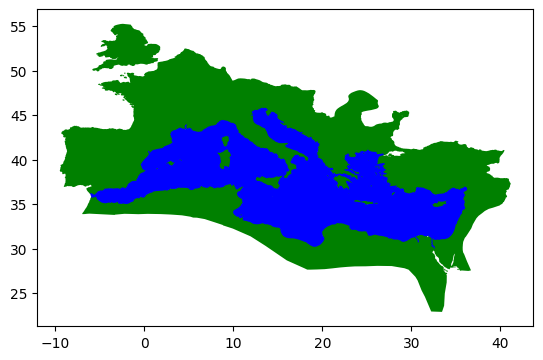

In [326]:
fig, ax = plt.subplots()
gpd.GeoSeries(pleiades_regions_merged_buffer_4326).plot(ax=ax, color="green")
gpd.GeoSeries(medsea_merged_buffer_4326).plot(ax=ax, color="blue")

<AxesSubplot: >

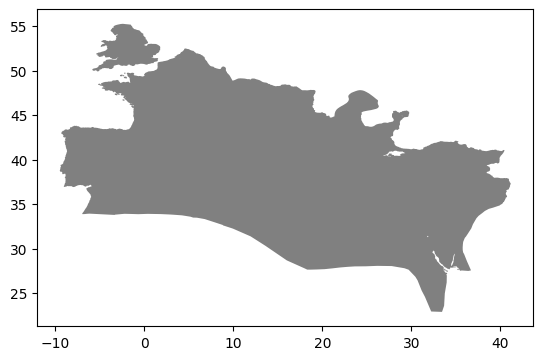

In [335]:
fig, ax = plt.subplots()
gpd.GeoSeries(pleiades_regions_merged_buffer_4326.union(medsea_merged_buffer_4326)).plot(ax=ax, color="grey")

In [344]:
LIST_sample = LIST.sample(1000)
sample_within = LIST_sample.within(pleiades_regions_merged_buffer_4326.union(medsea_merged_buffer_4326))

<AxesSubplot: >

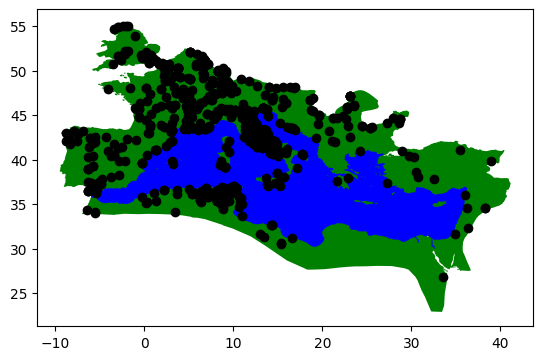

In [345]:
fig, ax = plt.subplots()
gpd.GeoSeries(pleiades_regions_merged_buffer_4326).plot(ax=ax, color="green")
gpd.GeoSeries(medsea_merged_buffer_4326).plot(ax=ax, color="blue")
LIST_sample[sample_within].plot(ax=ax, color="black")

In [347]:
%%time
withinRE = LIST.within(pleiades_regions_merged_buffer_4326.union(medsea_merged_buffer_4326))

CPU times: user 6min 47s, sys: 2.19 s, total: 6min 49s
Wall time: 7min


In [354]:
%%time
LIST["withinRE?"] = withinRE

CPU times: user 1.5 ms, sys: 3.49 ms, total: 4.98 ms
Wall time: 3.66 ms


In [355]:
LIST["withinRE?"].sum()

509018

# Trismegistos

In [ ]:
%%time
base_url = "https://www.trismegistos.org/dataservices/texrelations/{0}?source=edcs"
resps = []
edcs_trismegistos_dict = {}
for raw_id in LIST["EDCS-ID"]:
    try:
        id = raw_id[5:]
        url = base_url.format(str(id))
        resp_json = requests.get(url).json()
        edcs_trismegistos_dict[raw_id] = resp_json[0]["TM_ID"][0]
    except:
        edcs_trismegistos_dict[raw_id] = None

In [ ]:
with open("..data/large_data/edcs_trismegistos.picke", as f):
    pickle.dump(edcs_trismegistos_dict, f)

In [ ]:
LIST["tg_id"] = LIST["EDCS-ID"].apply(lambda x: edcs_trismegistos_dict[x])

# Extract trismegistos dates (where otherwise missing)

- in progres..., but once the above data are ready, we can continue with this

In [ ]:
# example for browser: https://www.trismegistos.org/dataservices/texrelations/24700151?source=edcs

In [ ]:
uris = LIST[(LIST["trismegistos_uri"].notnull()) & LIST["not_before"].isnull()]["trismegistos_uri"]
tg_ids = [tg_id.rpartition("/")[2] for tg_id in uris]
tg_ids[:10]

In [ ]:
for id in tg_ids:
    soup = BeautifulSoup(requests.get("https://www.trismegistos.org/text/" + id).text)
    print(soup.body.find("h4").next_sibling.get_text())


# Urban contexts

In [92]:
roman_cities = gpd.read_file("../data/roman_cities_pop.geojson")

In [93]:
roman_cities.sort_values("pop_est", ascending=False, inplace=True)
roman_cities.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,Area,Estimate Basis,num_of_structures,ID,level_0,Unnamed: 0_y,index,pop_sample,pop_est,pop_diff,geometry
991,Hanson2016_992,Roma,Rome,Italia (VII Etruria),Italy,1,43 B2,-700,NaN,Beloch 1886; Benario 1981; de Ligt 2012; Golvi...,1783.0,Fourteen Augustan regions,236,992,89.0,89.0,89.0,923406.0,923313.0,1.000101,POINT (12.48510 41.89278)
109,Hanson2016_110,Alexandria (Aegyptus),Alexandria,Aegyptus,Egypt,1,74 B2,-322,NaN,Beloch 1886; Bowman 2011; Cohen 2006; Humphrey...,972.0,Urban grid,30,110,3.0,3.0,3.0,410535.0,410502.0,1.000080,POINT (29.90373 31.19502)
179,Hanson2016_180,Lepcis Magna,Lebda,Africa Proconsularis,Libya,1,35 G2,-30,NaN,Bomgardner 2000; Golvin 1988; Humphrey 1986; L...,466.0,Ramparts,46,180,NaN,NaN,NaN,NaN,153722.0,NaN,POINT (14.29306 32.63833)
308,Hanson2016_309,Rhodus,Rhodes,Asia,Greece,3,60 G3,-408,NaN,Beloch 1886; Hansen 2006; Hansen and Nielsen 2...,412.0,Urban grid,17,309,NaN,NaN,NaN,NaN,130398.0,NaN,POINT (28.22701 36.44324)
1323,Hanson2016_1324,Antiochia (Syria),Antakya,Syria,Turkey,1,67 C4,-300,NaN,Boatwright 2000; Jones 1937; McEvedy 2011; Nel...,399.0,"Walls of Theodosius II, Justinian, and topography",33,1324,NaN,NaN,NaN,NaN,124930.0,NaN,POINT (36.16963 36.21017)


In [94]:
sum(roman_cities["pop_est"] < 1000)

0

In [95]:
cities_id_name_dict = dict(zip(roman_cities["ID"], roman_cities["Ancient Toponym"]))
cities_id_pop_dict = dict(zip(roman_cities["ID"], roman_cities["pop_est"]))


In [96]:
len(roman_cities)

1388

In [97]:
# total urban population
roman_cities["pop_est"].sum()

10214337.0

In [98]:
roman_cities.columns

Index(['Primary Key', 'Ancient Toponym', 'Modern Toponym', 'Province',
       'Country', 'Barrington Atlas Rank', 'Barrington Atlas Reference',
       'Start Date', 'End Date', 'Select Bibliography', 'Area',
       'Estimate Basis', 'num_of_structures', 'ID', 'level_0', 'Unnamed: 0_y',
       'index', 'pop_sample', 'pop_est', 'pop_diff', 'geometry'],
      dtype='object')

In [99]:
masks_dict = {}
masks_dict["large"] = roman_cities["pop_est"] >= 30000
masks_dict["medium"] = (roman_cities["pop_est"] >= 5000) & (roman_cities["pop_est"] < 30000)
masks_dict["small"] = small_cities_mask = roman_cities["pop_est"] < 5000

In [100]:
for mask in masks_dict.keys():
    print(mask, len(roman_cities[masks_dict[mask]]), roman_cities[masks_dict[mask]]["pop_est"].sum())

large 68 4641352.0
medium 337 4005250.0
small 983 1567735.0


In [101]:
geod = Geod(ellps="WGS84")
def get_dist_m(inscr_geo, city_geo):
    try:
        line_string = LineString([inscr_geo, city_geo])
        return np.round(geod.geometry_length(line_string), 2)
    except:
        return None

In [139]:
len(LIST)

525870

In [142]:
LIST.reset_index(drop=True, inplace=True)

In [210]:
LIST[~LIST.geometry.is_valid]

,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,clean_text_interpretive_word_EDCS,diplomatic_text,province,place,inscr_type,status_notation,inscr_process,status,partner_link,last_update,letter_size,type_of_inscription,work_status,year_of_find,present_location,text_edition,support_objecttype,support_material,support_decoration,keywords_term,people,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,language,language_EDCS,raw_dating,not_after,not_before,Longitude,Latitude,geotemporal?,geometry
37654,EDCS-66800022,None,NaN,NaN,NaN,DD(ominorum) nn(ostrorum) Dioclet(i)ani / et M...,DD nn Diocletani et Maximiani Augg et Constant...,NaN,DDominorum nnostrorum Diocletiani et Maximiani...,DDominorum nnostrorum Diocletiani et Maximiani...,NaN,Apulia et Calabria / Regio II,"Guardiola, Scampitella / Aeclanum",miliaria,"Augusti/Augustae, viri",litterae erasae,Augusti/Augustae; litterae erasae; miliaria;...,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,L,NaN,a: 293 to 305; b: 367 to 375,375.0,293.0,NaN,41.092522,False,POINT (nan 41.093)
98963,EDCS-50801194,None,NaN,NaN,NaN,V() L() A(),V L A,NaN,V L A,V L A,NaN,Britannia,Withington,tituli fabricationis,NaN,sigilla impressa,sigilla impressa; tituli fabricationis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,L,NaN,NaN,NaN,NaN,-1.954107,NaN,False,POINT (-1.954 nan)
420344,EDCS-31800336,None,NaN,NaN,NaN,Imp(erator) Caes(ar) M(arcus) Aurel[i]<us=O> /...,Imp Caes M Aurel s Antonin Pius Feli Aug Parth...,NaN,Imperator Caesar Marcus Aurelius Antoninus Piu...,Imperator Caesar Marcus Aurelius Antoninus Piu...,NaN,Syria,"Tadmur / Tadmer / Tadmor, iuxta (3) / Palmyra","miliaria, tituli operum","Augusti/Augustae, viri",NaN,Augusti/Augustae; miliaria; tituli operum; ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,L,NaN,212 to 212,212.0,212.0,NaN,34.563611,False,POINT (nan 34.564)
487107,EDCS-11600420,HD015591,https://www.trismegistos.org/text/237529,,Saenia Abra hic sita (e)st,Saenia Abra(!) hic sitast,Saenia Abra hic sita st,Saenia Abra hic sita est,Saenia Abra hic sita est,Saenia Abra hic sitast,SAENIA ABRA HIC SITA ST,Hispania citerior,Finestrat,tituli sepulcrales,NaN,NaN,tituli sepulcrales,http://db.edcs.eu/epigr/partner.php?s_language...,2006-05-03,NaN,epitaph,provisional,1806.0,NaN,\n Saenia Abra hic sita est\n,250,NaN,2000.0,92.0,[],epitaph,False,NaN,NaN,NaN,NULL,stele,False,Hispania citerior,False,Spain,False,NULL,False,NULL,False,Finestrat,False,Partida Alfarelles,False,L,NaN,1 to 100,1.0,100.0,-0.211856,NaN,False,POINT (-0.212 nan)
508290,EDCS-43201231,HD067771,https://www.trismegistos.org/text/404155,,Οὐγ(κία) ζʹ,Οὐγ(κία) ζʹ,Οὐγ ζʹ,Οὐγκία ζʹ,Οὐγκία ζʹ,Οὐγκία ζʹ,ΟΥΓ Ζʹ,Pannonia inferior,Polgardi,tituli possessionis,NaN,NaN,tituli possessionis,http://db.edcs.eu/epigr/partner.php?s_language...,2021-03-03,NaN,owner/artist inscription,provisional,-1990.0,NaN,\n \xce\x9f\xe1\xbd\x90\xce\xb3(\xce\xba\xe1\x...,140,115.0,2000.0,NaN,[],owner/artist inscription,False,57.0,NaN,NaN,Metal,instrumentum domesticum,False,unknown,False,unknown,False,NULL,False,NULL,False,NULL,False,NULL,False,L,NaN,NaN,351.0,450.0,18.306794,NaN,False,POINT (18.307 nan)
508291,EDCS-59300051,HD067770,https://www.trismegistos.org/text/69

In [220]:
def ckdnearest(city_type):
    cities_subset = roman_cities[masks_dict[city_type]]
    incr_ids = LIST[(LIST.geometry.is_valid) & (~LIST.geometry.is_empty)]["LIST-ID"]
    insr_geometries = np.array(list(LIST[(LIST.geometry.is_valid) & (~LIST.geometry.is_empty)].geometry.apply(lambda x: (x.x, x.y))))
    incr_ids_missing = LIST[(~LIST.geometry.is_valid) | (LIST.geometry.is_empty)]["LIST-ID"]
    cities_geometries = np.array(list(cities_subset.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(cities_geometries)
    dist, idx = btree.query(insr_geometries, k=1)
    inscr_cities_name_dict = dict(zip(incr_ids, cities_subset.iloc[idx]["Ancient Toponym"]))
    inscr_cities_pop_dict = dict(zip(incr_ids, cities_subset.iloc[idx]["pop_est"]))
    inscr_cities_geo_dict = dict(zip(incr_ids, cities_subset.iloc[idx].geometry))
    for id in incr_ids_missing:
        inscr_cities_name_dict[id] = None
        inscr_cities_pop_dict[id] = None
        inscr_cities_geo_dict[id] = None
    LIST[city_type + "_city_name"] = LIST["LIST-ID"].apply(lambda x: inscr_cities_name_dict[x])
    LIST[city_type + "_city_geo"] = LIST["LIST-ID"].apply(lambda x: inscr_cities_geo_dict[x])
    LIST[city_type + "_city_pop"] = LIST["LIST-ID"].apply(lambda x: inscr_cities_pop_dict[x])
    LIST[city_type + "_city_dist"] = LIST.apply(lambda row: get_dist_m(row.geometry, row[city_type + "_city_geo"]), axis=1)

In [221]:
ckdnearest("large")
ckdnearest("medium")
ckdnearest("small")

In [281]:
def get_urban_context(row):
    urban_context_city = None
    urban_context_pop_est = None
    #if (row.geometry == None) | ~(row.geometry.is_valid) | (row.geometry.is_empty):
    if row.geometry.is_empty:
        urban_context = None
    else:
        urban_context = "rural"
        buffer = 5000
        for context in ["large", "medium", "small"]:
            if row[context + "_city_dist"] <= buffer:
                urban_context = context
                urban_context_city = row[context + "_city_name"]
                urban_context_pop_est = row[context + "_city_pop"]
                break
    return urban_context, urban_context_city, urban_context_pop_est

urban_contexts = LIST.apply(lambda row: get_urban_context(row), axis=1)

LIST["urban_context"] = [el[0] for el in urban_contexts]
LIST["urban_context_city"] = [el[1] for el in urban_contexts]
LIST["urban_context_pop_est"] = [el[2] for el in urban_contexts]

In [282]:
contexts = ["large", "medium", "small", "rural"]
for context in contexts:
    print(context, (LIST["urban_context"]==context).sum())

large 156892
medium 131430
small 81527
rural 142130


In [283]:
(LIST["urban_context"].isnull()).sum()

13891

In [286]:
# perhaps thesecolumns could be useful for some analysis, but not now...
LIST.drop(columns=['large_city_name', 'large_city_geo', 'large_city_dist', 'large_city_pop', 'medium_city_name', 'medium_city_geo', 'medium_city_pop', 'medium_city_dist', 'small_city_name', 'small_city_geo','small_city_dist', 'small_city_pop'], inplace=True)

In [287]:
len(LIST[LIST["urban_context_city"]=="Roma"])

120768

In [288]:
LIST[LIST["urban_context_city"]=="Roma"].sample(50)

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,clean_text_interpretive_word_EDCS,diplomatic_text,province,place,inscr_type,status_notation,inscr_process,status,partner_link,last_update,letter_size,type_of_inscription,work_status,year_of_find,present_location,text_edition,support_objecttype,support_material,support_decoration,keywords_term,people,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,language,language_EDCS,raw_dating,not_after,not_before,Longitude,Latitude,geotemporal?,geometry,urban_context,urban_context_city,urban_context_pop_est
357626,357627,EDCS-38700419,None,NaN,NaN,NaN,Lucianus {i}studiosus,Lucianus istudiosus,NaN,Lucianus studiosus,Lucianus studiosus,NaN,Roma,Roma,"inscriptiones christianae, tituli sepulcrales","nomen singulare, officium/professio, viri",NaN,inscriptiones christianae; nomen singulare; ...,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,L,NaN,291 to 325,325.0,291.0,12.482932,41.89332,True,POINT (12.483 41.893),large,Roma,923313.0
324333,324334,EDCS-17202739,None,NaN,NaN,NaN,]/scens VP[,scens VP,NaN,scens VP,scens VP,NaN,Roma,Roma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,L,NaN,NaN,NaN,NaN,12.482932,41.89332,False,POINT (12.483 41.893),large,Roma,923313.0
391419,391420,EDCS-35300147,None,NaN,NaN,NaN,Digni / Iunior,Digni Iunior,NaN,Digni Iunior,Digni Iunior,NaN,Roma,Roma,"inscriptiones christianae, tituli sepulcrales",viri,NaN,inscriptiones christianae; tituli sepulcrales...,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,L,NaN,301 to 500,500.0,301.0,12.482932,41.89332,True,POINT (12.483 41.893),large,Roma,923313.0
364374,364375,EDCS-34900581,None,NaN,NaN,NaN,be]ne mer[enti 3] / [3]is fec[it,bene mer is fecit,NaN,bene merenti is fecit,bene merenti is fecit,NaN,Roma,Roma,"inscriptiones christianae, tituli sepulcrales",NaN,NaN,inscriptiones christianae; tituli sepulcrales,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,L,NaN,301 to 500,500.0,301.0,12.482932,41.89332,True,POINT (12.483 41.893),large,Roma,923313.0
359593,359594,EDCS-39900259,None,NaN,NaN,NaN,Dominis nostris Valentiniano et / Valente cons...,Dominis nostris Valentiniano et Valente conss ...,NaN,Dominis nostris Valentiniano et Valente conssu...,Dominis nostris Valentiniano et Valente conssu...,NaN,Roma,Roma,"inscriptiones christianae, tituli sepulcrales",NaN,NaN,inscriptiones christianae; tituli sepulcrales,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,L,NaN,365 to 365,365.0,365.0,12.482932,41.89332,True,POINT (12.483 41.893),large,Roma,923313.0
315765,315766,EDCS-13200365,None,NaN,NaN,NaN,D(is) M(anibus) / L(ucio) Marcio L(uci) f(ilio...,D M L Marcio L f Honorato L Marcius Phoebus,NaN,Dis Manibus Lucio Marcio Luci filio Honorato L...,Dis Manibus Lucio Marcio Luci filio Honorato L...,NaN,Roma,Roma,tituli sepulcrales,"tria nomina, viri",NaN,tituli sepulcrales; tria nomina; viri,NaN,N

In [290]:
LIST.columns

Index(['LIST-ID', 'EDCS-ID', 'EDH-ID', 'trismegistos_uri', 'pleiades_id',
       'transcription', 'inscription', 'clean_text_conservative',
       'clean_text_interpretive_sentence', 'clean_text_interpretive_word',
       'clean_text_interpretive_word_EDCS', 'diplomatic_text', 'province',
       'place', 'inscr_type', 'status_notation', 'inscr_process', 'status',
       'partner_link', 'last_update', 'letter_size', 'type_of_inscription',
       'work_status', 'year_of_find', 'present_location', 'text_edition',
       'support_objecttype', 'support_material', 'support_decoration',
       'keywords_term', 'people', 'type_of_inscription_clean',
       'type_of_inscription_certainty', 'height_cm', 'width_cm', 'depth_cm',
       'material_clean', 'type_of_monument_clean',
       'type_of_monument_certainty', 'province_label_clean',
       'province_label_certainty', 'country_clean', 'country_certainty',
       'findspot_ancient_clean', 'findspot_ancient_certainty',
       'modern_region_cle

In [ ]:
# Preliminary testing of new LIRE... (whehther "withinRE" works properly etc...)

In [356]:
LIRE = LIST[
    (LIST["geotemporal?"])
    &(LIST["withinRE?"])
    & ((LIST["not_after"]>=-50)
       | (LIST["not_before"]<=350))]

In [357]:
print(LIRE["EDH-ID"].isnull().sum())
print(LIRE["EDH-ID"].notnull().sum())

138489
64608


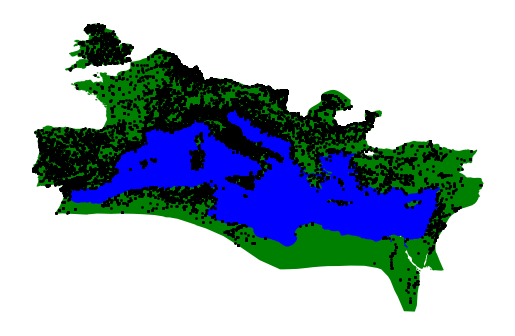

In [359]:
fig, ax = plt.subplots()
gpd.GeoSeries(pleiades_regions_merged_buffer_4326).plot(ax=ax, color="green")
gpd.GeoSeries(medsea_merged_buffer_4326).plot(ax=ax, color="blue")
LIRE.plot(ax=ax, color="black", markersize=1)
ax.set_axis_off()

# Replace invalid geometries with Nones

In [6]:
LIST["valid_nonempty"] = ((LIST.geometry.is_valid) & ~(LIST.geometry.is_empty))

In [8]:
def geo_or_none(row):
    if row["valid_nonempty"]:
        return row.geometry
    else:
        return None

In [9]:
new_geometry = LIST.apply(lambda row: geo_or_none(row), axis=1)

In [14]:
LIST.geometry = new_geometry

In [17]:
LIST.drop(columns=["valid_nonempty"], inplace=True)

# Saving the data

In [19]:
LIST.to_parquet("../data/large_data/LIST_contexts.parquet")